In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import skimage
import toml
import glob
import joblib
import pandas as pd
import seaborn as sns

from tqdm.auto import tqdm
from scipy.stats import binned_statistic_2d

In [5]:
config = toml.load("../preprocessing/config.toml")
fig_dir = config["dirs"]["figs"]
data_dir = config["dirs"]["data"]

In [6]:
dist_df = pd.read_parquet(os.path.join(data_dir, "dataframes/accuracy_v_distance_from_camera.parquet"))

In [9]:
visibility_score = .5

In [10]:
use_cols = ["centroid_x_world","centroid_y_world","centroid_z_world"]

cameras = dist_df["camera"].unique()

ncols = len(cameras)
col_wrap = 3

nrows = int(np.ceil(ncols / col_wrap))
use_dist_df = dist_df.query("kpoint_score > @visibility_score")

In [11]:
stat = {}
x_edges = {}
y_edges = {}

for _camera in tqdm(cameras):
    use_df = use_dist_df.query("camera == @_camera").dropna(
        subset=[
            "angle_from_camera_degrees",
            "dist_from_camera_mm",
            "error_kpoint_l2_mm",
        ]
    )
    stat[_camera], x_edges[_camera], y_edges[_camera], _ = binned_statistic_2d(
        use_df["angle_from_camera_degrees"],
        use_df["dist_from_camera_mm"],
        use_df["error_kpoint_l2_mm"],
        statistic=np.nanmedian,
        bins=[40, 40],
    )
use_df = use_dist_df.dropna(
        subset=[
            "angle_from_camera_degrees",
            "dist_from_camera_mm",
            "error_kpoint_l2_mm",
        ]
    )
stat["all"], x_edges["all"], y_edges["all"], _ = binned_statistic_2d(
    use_df["angle_from_camera_degrees"],
    use_df["dist_from_camera_mm"],
    use_df["error_kpoint_l2_mm"],
    statistic=np.nanmedian,
    bins=[40, 40],
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
from qd_analysis.fig import setup_plotting_env

In [13]:
setup_plotting_env()

In [14]:
im_kwargs = {
    "cmap": "inferno",
    "vmin": 0,
    "vmax": 7
}

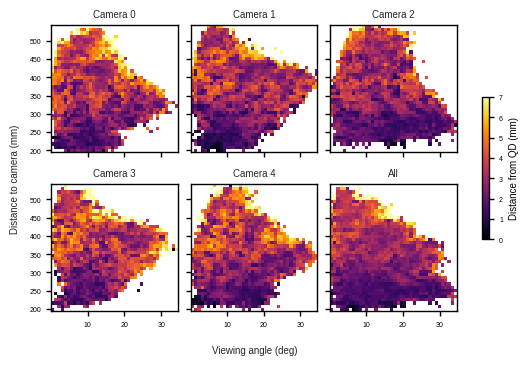

In [15]:
fig, ax = plt.subplots(nrows, col_wrap, figsize=(1.9 * col_wrap, 1.8 * nrows), sharex=True, sharey=True)
for i, (_key, _ax) in enumerate(zip(stat.keys(), ax.ravel())):
    h = _ax.imshow(
        stat[_key].T,
        origin="lower",
        aspect="auto",
        extent=[x_edges[_camera][0], x_edges[_camera][-1], y_edges[_camera][0], y_edges[_camera][-1]],
        **im_kwargs,
    )
    # _ax.axhline(y=300, lw=1.5)
    if _key != "all":
        _ax.set_title(f"Camera {i}")
    else:
        _ax.set_title("All")
fig.supxlabel("Viewing angle (deg)", fontsize=7, ha="center", x=.45)
fig.supylabel("Distance to camera (mm)", fontsize=7)
fig.tight_layout()
fig.colorbar(h, ax=ax.ravel(), shrink=.5, label="Distance from QD (mm)")
fig.savefig(os.path.join(fig_dir, "keypoint_performance_per-camera_distance_v_angle.pdf"), bbox_inches="tight", dpi=600)
# plt.title("Mean keypoint error (mm)")
# plt.colorbar(label="Error (mm)")
# plt.show()

# Now make a map in world coordinates of approximate performance

In [16]:
from sklearn.decomposition import PCA

In [72]:
xy_df = dist_df.groupby(["session","frame_index"])[["centroid_x_world","centroid_y_world"]].first()

In [73]:
theta = np.pi / 10
R = np.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta),  np.cos(theta)]])
xy_rot_df = xy_df @ R.T

In [74]:
xy_rot_df.columns = ["centroid_x_world_rotated", "centroid_y_world_rotated"]

In [75]:
thresholds = {}
thresholds["distance"] = 350
thresholds["angle"] = 20

norm_dist = dist_df["dist_from_camera_mm"] / dist_df["dist_from_camera_mm"].max()
norm_angle = dist_df["angle_from_camera_degrees"] / dist_df["angle_from_camera_degrees"].max()
dist_df["norm_dist"] = norm_angle + norm_dist
dist_df["threshold_distance"] = dist_df["dist_from_camera_mm"] < thresholds["distance"]
dist_df["threshold_angle"] = dist_df["angle_from_camera_degrees"] < thresholds["angle"]

In [76]:
use_dist_df = dist_df.query("kpoint_score > .5")

In [77]:
use_cols = [
    "dist_from_camera_mm",
    "angle_from_camera_degrees",
    "error_kpoint_l2_mm",
    # "centroid_x_world_rotated",
    # "centroid_y_world_rotated",
]

In [78]:
use_dist_df = use_dist_df.groupby(["session","frame_index","camera"])[use_cols].mean().reset_index()

In [79]:
closest_cam = use_dist_df.sort_values("dist_from_camera_mm").groupby(["session","frame_index"])["dist_from_camera_mm"].head(1).index.dropna()
dists = use_dist_df.loc[closest_cam,["session","frame_index","error_kpoint_l2_mm"]]

In [80]:
# plt_df = pd.merge(dists, xyz, on=["session","frame_index"]).dropna()
plt_df = pd.merge(dists, xy_rot_df, on=["session","frame_index"]).dropna()

In [81]:
quantiles = [.25, .5, .75]

In [82]:
stat = {}
x_edges = {}
y_edges = {}

In [83]:
for _quantile in quantiles:
    stat[_quantile], x_edges[_quantile], y_edges[_quantile], _ = binned_statistic_2d(
        plt_df["centroid_x_world_rotated"],
        plt_df["centroid_y_world_rotated"],
        plt_df["error_kpoint_l2_mm"],
        statistic=lambda x: np.quantile(x, _quantile),
        bins=[40, 40]
    )

In [84]:
camera_pos = dist_df.drop_duplicates("camera").set_index("camera")[["camera_x_world","camera_y_world"]]
rot_camera_pos = camera_pos @ R_square.T

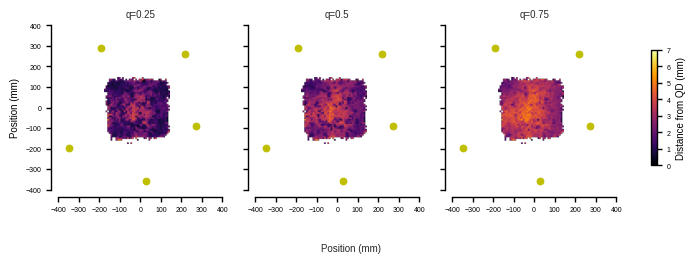

In [85]:
fig, ax = plt.subplots(1, len(quantiles), figsize=(3. * len(quantiles), 3.), sharex=True, sharey=True)
for _quantile, _ax in zip(quantiles, ax):
    h = _ax.imshow(
        stat[_quantile].T,
        origin="lower",
        extent=[
            x_edges[_quantile][0],
            x_edges[_quantile][-1],
            y_edges[_quantile][0],
            y_edges[_quantile][-1],
        ],
        cmap="inferno",
        vmin=0,
        vmax=7,
    )
    for _cam, _vals in rot_camera_pos.iterrows():
        _ax.scatter(_vals[0],_vals[1],color="y")
    _ax.set_title(f"q={_quantile}")

ax[0].set_xlim(-400,400)
ax[0].set_ylim(-400,400)
fig.supxlabel("Position (mm)", x=.45, ha="center", fontsize=7)
ax[0].set_ylabel("Position (mm)")
sns.despine(offset=5, trim=True)
fig.colorbar(h, ax=ax.ravel(), shrink=.5, label="Distance from QD (mm)")
fig.savefig(os.path.join(fig_dir, "keypoint_performance_xy_quantiles_with_camera_pos.pdf"), bbox_inches="tight", dpi=600)